In [43]:
import pandas as pd
from yahoo_fin import options
import numpy as np
import datetime
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import optimize
from scipy.stats import norm
import modulesForCalibration as mfc

today = datetime.datetime.today()



In [24]:
import yfinance as yf

tickers = ['META']
for ticker in tickers:
    ticker_yahoo = yf.Ticker(ticker)
    data = ticker_yahoo.history()
    last_quote = data['Close'].iloc[-1]
    print(ticker, last_quote)
meta_close = last_quote

META 302.54998779296875


In [50]:
# https://ycharts.com/indicators/10_year_treasury_rate
r = 0.0433
q = 0

In [26]:
import yfinance as yf
fb = yf.Ticker("META")


In [5]:
fb_df = pd.DataFrame()
for date in fb.options:
    calls = fb.option_chain(date).calls
    puts = fb.option_chain(date).puts
    calls['Option type'] = 'Call'
    calls['Maturity date'] = date
    puts['Maturity date'] = date
    puts['Option type'] = 'Put'
    fb_df = pd.concat([fb_df,calls,puts])

In [6]:
print(fb.options)

('2023-09-22', '2023-09-29', '2023-10-06', '2023-10-13', '2023-10-20', '2023-10-27', '2023-11-17', '2023-12-15', '2024-01-19', '2024-02-16', '2024-03-15', '2024-06-21', '2024-09-20', '2025-01-17', '2025-06-20', '2025-12-19', '2026-01-16')


In [7]:
fb_df.columns

Index(['contractSymbol', 'lastTradeDate', 'strike', 'lastPrice', 'bid', 'ask',
       'change', 'percentChange', 'volume', 'openInterest',
       'impliedVolatility', 'inTheMoney', 'contractSize', 'currency',
       'Option type', 'Maturity date'],
      dtype='object')

In [8]:
fb_df = fb_df.loc[(fb_df.strike > 200) & (fb_df.strike <400)] # Filter deep OTM and ITM

In [27]:
fb_df.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Option type,Maturity date,Mid,Maturity,Days to maturity
17,META230922C00205000,2023-09-14 13:30:02+00:00,205.0,101.73,0.0,0.0,0.0,0.0,2.0,0.0,0.00001,True,REGULAR,USD,Call,2023-09-22,0.0,2023-09-22,2
18,META230922C00210000,2023-09-15 19:50:00+00:00,210.0,89.80,0.0,0.0,0.0,0.0,5.0,0.0,0.00001,True,REGULAR,USD,Call,2023-09-22,0.0,2023-09-22,2
19,META230922C00215000,2023-09-15 15:27:26+00:00,215.0,88.96,0.0,0.0,0.0,0.0,3.0,0.0,0.00001,True,REGULAR,USD,Call,2023-09-22,0.0,2023-09-22,2
20,META230922C00220000,2023-09-18 13:49:35+00:00,220.0,80.47,0.0,0.0,0.0,0.0,1.0,0.0,0.00001,True,REGULAR,USD,Call,2023-09-22,0.0,2023-09-22,2
21,META230922C00225000,2023-09-15 13:40:51+00:00,225.0,82.85,0.0,0.0,0.0,0.0,10.0,0.0,0.00001,True,REGULAR,USD,Call,2023-09-22,0.0,2023-09-22,2


In [28]:
 # fb_df['Mid'] = fb_df[['bid','ask']].mean(axis=1)
fb_df['Mid'] = fb_df['lastPrice']

In [15]:
strikes = fb_df.strike.unique()
print(strikes)

[205.  210.  215.  220.  225.  230.  235.  240.  245.  247.5 250.  252.5
 255.  257.5 260.  262.5 265.  267.5 270.  272.5 275.  277.5 280.  282.5
 285.  287.5 290.  292.5 295.  297.5 300.  302.5 305.  307.5 310.  312.5
 315.  317.5 320.  322.5 325.  327.5 330.  332.5 335.  337.5 340.  342.5
 345.  347.5 350.  352.5 355.  360.  365.  370.  375.  380.  385.  390.
 395. ]


In [30]:
fb_df['Maturity'] = fb_df['Maturity date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

In [31]:
fb_df['Days to maturity'] = (fb_df['Maturity'] - today).dt.days

In [32]:
maturities = np.sort(fb_df['Days to maturity'].unique())

In [33]:
print(maturities)

[  2   9  16  23  30  37  58  86 121 149 177 275 366 485 639 821 849]


In [34]:
#fb_df = fb_df.loc[(fb_df['Days to maturity'] <= 150) & (fb_df['Days to maturity'] >= 38)]

In [35]:
fb_df.shape

(1159, 19)

In [14]:
maturities = np.sort(fb_df['Days to maturity'].unique())

In [29]:
fb_calls = fb_df[fb_df['Option type'] == 'Call'][['Days to maturity', 'strike', 'Mid']]

In [38]:
fb_calls.head()

,Days to maturity,strike,Mid
17,2,205.0,101.73
18,2,210.0,89.80
19,2,215.0,88.96
20,2,220.0,80.47
21,2,225.0,82.85


In [20]:
X, Y = np.meshgrid(strikes, maturities)

In [34]:
callPrices = np.empty([len(maturities), len(strikes)])

In [37]:
for i in range(len(maturities)):
    s = fb_calls[fb_calls['Days to maturity'] == maturities[i]]['strike']
    price = fb_calls[fb_calls['Days to maturity'] == maturities[i]]['Mid']
    f = interpolate.interp1d(s, price, bounds_error=False, fill_value='extrapolate')
    callPrices[i, :] = f(strikes)

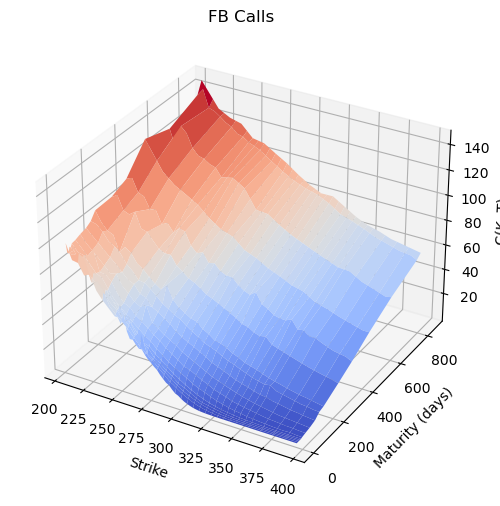

In [38]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, callPrices, cmap=cm.coolwarm)
ax.set_ylabel('Maturity (days)') 
ax.set_xlabel('Strike') 
ax.set_zlabel('C(K, T)')
ax.set_title('FB Calls')
plt.show()

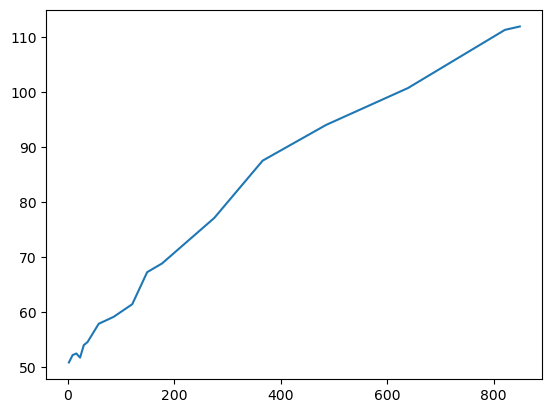

In [44]:
strike250 = fb_calls.loc[fb_calls['strike'] == 250]
plt.plot(strike250['Days to maturity'], strike250['Mid'])
plt.show() # Just to check if it's not constant

In [45]:
maturities

array([  2,   9,  16,  23,  30,  37,  58,  86, 121, 149, 177, 275, 366,
       485, 639, 821, 849], dtype=int64)

In [46]:
fb_puts = fb_df[fb_df['Option type'] == 'Put'][['Days to maturity', 'strike', 'Mid']]

In [17]:
putPrices = np.empty([len(maturities), len(strikes)])

In [39]:
for i in range(len(maturities)):
    s = fb_puts[fb_puts['Days to maturity'] == maturities[i]]['strike']
    price = fb_puts[fb_puts['Days to maturity'] == maturities[i]]['Mid']
    f = interpolate.interp1d(s, price, bounds_error=False, fill_value='extrapolate')
    putPrices[i, :] = f(strikes)

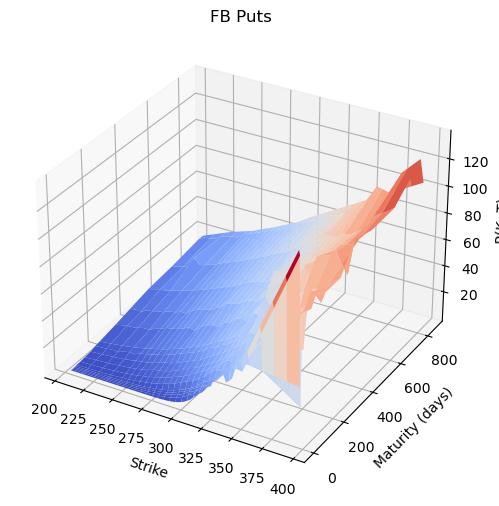

In [26]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, putPrices, cmap=cm.coolwarm)
ax.set_ylabel('Maturity (days)') 
ax.set_xlabel('Strike') 
ax.set_zlabel('P(K, T)')
ax.set_title('FB Puts')
plt.show()

In [50]:
fb_puts.strike.unique()

array([205. , 210. , 215. , 220. , 225. , 230. , 235. , 240. , 245. ,
       247.5, 250. , 252.5, 255. , 257.5, 260. , 262.5, 265. , 267.5,
       270. , 272.5, 275. , 277.5, 280. , 282.5, 285. , 287.5, 290. ,
       292.5, 295. , 297.5, 300. , 302.5, 305. , 307.5, 310. , 312.5,
       315. , 317.5, 320. , 322.5, 325. , 327.5, 330. , 332.5, 335. ,
       337.5, 340. , 342.5, 345. , 350. , 360. , 355. , 365. , 370. ,
       375. , 380. , 390. , 395. , 385. ])

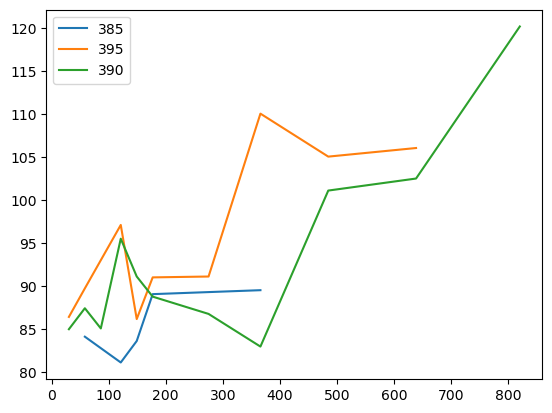

In [40]:
strike385 = fb_puts.loc[fb_puts['strike'] == 385]
strike395 = fb_puts.loc[fb_puts['strike'] == 395]
strike390 = fb_puts.loc[fb_puts['strike'] == 390]
plt.plot(strike385['Days to maturity'], strike385['Mid'], label= '385')
plt.plot(strike395['Days to maturity'], strike395['Mid'], label= '395')
plt.plot(strike390['Days to maturity'], strike390['Mid'], label= '390')
plt.legend()
plt.show() # Just to check if it's not constant

In [52]:
putPrices[-1]

array([     nan,      nan,      nan, 23.54   , 25.37   , 27.2    ,
       28.665  , 30.13   , 31.595  , 32.3275 , 33.06   , 34.05875,
       35.0575 , 36.05625, 37.055  , 38.05375, 39.0525 , 40.05125,
       41.05   , 42.15   , 43.25   , 44.35   , 45.45   , 46.55   ,
       47.65   , 48.75   , 49.85   , 51.35   , 52.85   , 54.35   ,
       55.85   , 57.1425 , 58.435  , 59.7275 , 61.02   , 62.3125 ,
       63.605  , 64.8975 , 66.19   , 67.4825 , 68.775  , 70.0675 ,
       71.36   , 72.6525 , 73.945  , 75.2375 , 76.53   , 77.8225 ,
       79.115  , 80.4075 , 81.7    ,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,
            nan])

In [53]:
len(strikes)

61

In [54]:
def BS_d1(S, K, r, q, sigma, tau):
    ''' Computes d1 for the Black Scholes formula '''
    d1 = 1.0*(np.log(1.0 * S/K) + (r - q + sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d1

def BS_d2(S, K, r, q, sigma, tau):
    ''' Computes d2 for the Black Scholes formula '''
    d2 = 1.0*(np.log(1.0 * S/K) + (r - q - sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d2

def BS_price(type_option, S, K, r, q, sigma, T, t=0):
    ''' Computes the Black Scholes price for a 'call' or 'put' option '''
    tau = T - t
    d1 = BS_d1(S, K, r, q, sigma, tau)
    d2 = BS_d2(S, K, r, q, sigma, tau)
    if type_option == 'Call':
        price = S * np.exp(-q * tau) * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    elif type_option == 'Put':
        price = K * np.exp(-r * tau) * norm.cdf(-d2) - S * np.exp(-q * tau) * norm.cdf(-d1) 
    return price

### part need to be finished ###
# auxiliary function for computing implied vol
def aux_imp_vol(sigma, P, type_option, S, K, r, q, T, t=0):
    # roughly 1-2 lines
    bs = BS_price(type_option, S, K, r, q, sigma, T, t)
    return bs - P

In [55]:
fb_df['Years to maturity'] = fb_df['Days to maturity'] / 360

In [56]:
fb_df.describe()

,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,Mid,Days to maturity,Years to maturity
count,1159.000000,1159.000000,1158.000000,1159.000000,1159.0,1159.0,1117.000000,1158.000000,1159.000000,1159.000000,1159.000000,1159.000000
mean,295.448663,35.195004,0.756779,0.777265,0.0,0.0,241.146822,0.566494,0.057282,35.195004,182.586713,0.507185
std,53.775257,33.529340,7.944518,8.164445,0.0,0.0,1098.616534,9.370340,0.107052,33.529340,233.756403,0.649323
min,205.000000,0.010000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000010,0.010000,2.000000,0.005556
25%,250.000000,5.330000,0.000000,0.000000,0.0,0.0,3.000000,0.000000,0.000010,5.330000,23.000000,0.063889
50%,295.000000,25.830000,0.000000,0.000000,0.0,0.0,11.000000,0.000000,0.007822,25.830000,86.000000,0.238889
75%,340.000000,58.925000,0.000000,0.000000,0.0,0.0,61.000000,0.000000,0.062509,58.925000,275.000000,0.763889
max,395.000000,144.290000,100.800000,102.500000,0.0,0.0,13203.000000,228.000000,1.337650,144.290000,849.000000,2.358333


In [57]:
def imp_vol(fun, a, b, args):
    try:
        result = optimize.brentq(fun, a, b, args = args)
    except:
        result = 0
    return result

In [58]:
fb_df['Implied vol calc'] = fb_df.apply(lambda x: imp_vol(aux_imp_vol, -0.1, 10, args = (x['Mid'], x['Option type'], meta_close, 
                                                                           x['strike'], r, q, x['Years to maturity'])), axis=1)

In [59]:
fb_df.loc[fb_df['Implied vol calc'] == 0]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,inTheMoney,contractSize,currency,Option type,Maturity date,Mid,Maturity,Days to maturity,Years to maturity,Implied vol calc


In [60]:
fb_df['Implied vol calc'].describe()

count    1.159000e+03
mean     4.308051e-01
std      2.840066e-01
min      2.015429e-14
25%      3.738111e-01
50%      4.015604e-01
75%      4.402850e-01
max      4.250511e+00
Name: Implied vol calc, dtype: float64

In [62]:
fb_df[['Implied vol calc', 'impliedVolatility', 'Mid', 'strike', 'Years to maturity', 'Days to maturity', 'Option type']].head(20)

,Implied vol calc,impliedVolatility,Mid,strike,Years to maturity,Days to maturity,Option type
17,4.250511e+00,0.00001,101.73,205.0,0.005556,2,Call
18,6.738630e-13,0.00001,89.80,210.0,0.005556,2,Call
19,2.911973e+00,0.00001,88.96,215.0,0.005556,2,Call
20,4.191853e-13,0.00001,80.47,220.0,0.005556,2,Call
21,3.720601e+00,0.00001,82.85,225.0,0.005556,2,Call
22,3.011429e-14,0.00001,71.42,230.0,0.005556,2,Call
23,7.060986e-13,0.00001,65.38,235.0,0.005556,2,Call
24,9.955405e-13,0.00001,60.42,240.0,0.005556,2,Call
25,2.080325e-13,0.00001,55.48,245.0,0.005556,2,Call
26,1.501631e+00,0.00001,55.55,247.5,0.005556,2,Call


In [63]:
BS_price('Call', meta_close, 225, r, q, 3.720601, 0.008333, t=0)

86.89651082009235

In [52]:
# Parameters
alpha = 1.5
eta = 0.2
model = 'Heston'
n = 12

In [45]:
#set 1: promising starting point
# params1 = (1.0, 0.02, 0.05, -0.4, 0.08)
# params2 = (3.0, 0.06, 0.10, -0.6, 0.04)
    
# set 2: This one too
#params1 = (6.0, 0.05, 0.04, +0.7, 0.10)
#params2 = (1.0, 0.02, 0.10, -0.8, 0.04)
    
#set 3: tricky starting point
#params1 = (1.0, 0.0625, 0.0125, -0.7, 0.05)
#params2 = (8.0, 0.02,   0.05,   +0.6, 0.12)
    
# set 4: non-informative
params1 = (1.0, 0.001, 0.01, -1, 0)
params2 = (20.0, 0.4, 0.6, +1, 5) 

In [47]:
marketPrices = callPrices
maturities_yr = maturities / 365

In [78]:
iArray = []
rmseArray = []
rmseMin = 1e10
for i in mfc.myRange(0, 1, 0.05):
    
    params = i*np.array(params1) + (1.0-i)*np.array(params2)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities_yr, strikes, r, q, meta_close, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

print(rmseMin)
print(optimParams)

7.714784439376582
[ 7.65     0.14065  0.2165  -0.3      1.75   ]


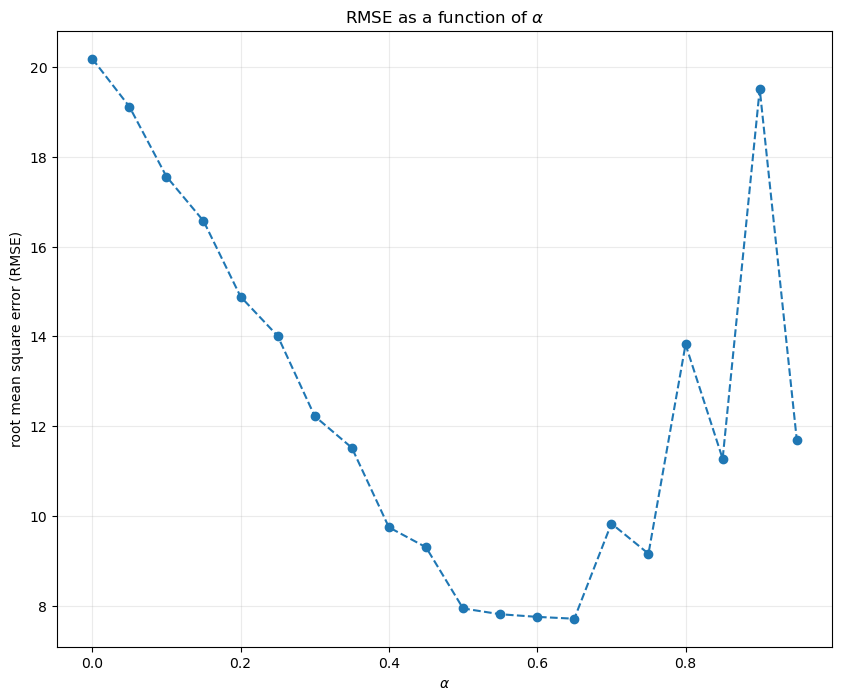

In [79]:
fig = plt.figure(figsize=(10,8))
plt.plot(iArray, rmseArray, 'o--')
plt.grid(alpha=0.25)
plt.xlabel('$\\alpha$')
plt.ylabel('root mean square error (RMSE)')
plt.title('RMSE as a function of $\\alpha$')
plt.show()

In [84]:
ind_iter = 1
rmseMin = 1.0e6

for kappa in mfc.myRange(7.50,7.80,0.15):
    for theta in mfc.myRange(0.1,0.2,0.05):
        for sig in mfc.myRange(0.18,0.22,0.02):
            for rho in mfc.myRange(-0.4,-0.2,0.1):
                for v0 in mfc.myRange(1.65,1.85,0.1):
                    params = []
                    params.append(kappa)
                    params.append(theta)
                    params.append(sig)
                    params.append(rho)
                    params.append(v0)
                    
                    print('i = ' + str(ind_iter))
                    ind_iter += 1
                    print(params)
                    rmse = mfc.eValue(params, marketPrices, maturities_yr, strikes, r, q, meta_close, alpha, eta, n, model)
                    
                    if (rmse < rmseMin):
                        rmseMin = rmse
                        params2 = params
                        print('\nnew min found')
                        print(rmseMin)
                        print(params2)
                        print('')

print('\nSolution of grid search:')                        
print(params2)
print('Optimal rmse = ' + str(rmseMin))

i = 1
[7.5, 0.01, 0.18, -0.4, 1.65]

new min found
20.650813023110157
[7.5, 0.01, 0.18, -0.4, 1.65]

i = 2
[7.5, 0.01, 0.18, -0.4, 1.75]

new min found
19.92971661207595
[7.5, 0.01, 0.18, -0.4, 1.75]

i = 3
[7.5, 0.01, 0.18, -0.4, 1.85]
i = 4
[7.5, 0.01, 0.18, -0.30000000000000004, 1.65]
i = 5
[7.5, 0.01, 0.18, -0.30000000000000004, 1.75]
i = 6
[7.5, 0.01, 0.18, -0.30000000000000004, 1.85]
i = 7
[7.5, 0.01, 0.18, -0.20000000000000004, 1.65]
i = 8
[7.5, 0.01, 0.18, -0.20000000000000004, 1.75]
i = 9
[7.5, 0.01, 0.18, -0.20000000000000004, 1.85]
i = 10
[7.5, 0.01, 0.19999999999999998, -0.4, 1.65]
i = 11
[7.5, 0.01, 0.19999999999999998, -0.4, 1.75]
i = 12
[7.5, 0.01, 0.19999999999999998, -0.4, 1.85]
i = 13
[7.5, 0.01, 0.19999999999999998, -0.30000000000000004, 1.65]
i = 14
[7.5, 0.01, 0.19999999999999998, -0.30000000000000004, 1.75]
i = 15
[7.5, 0.01, 0.19999999999999998, -0.30000000000000004, 1.85]
i = 16
[7.5, 0.01, 0.19999999999999998, -0.20000000000000004, 1.65]
i = 17
[7.5, 0.01, 0.19

i = 135
[7.65, 0.015, 0.21999999999999997, -0.20000000000000004, 1.85]
i = 136
[7.65, 0.02, 0.18, -0.4, 1.65]
i = 137
[7.65, 0.02, 0.18, -0.4, 1.75]
i = 138
[7.65, 0.02, 0.18, -0.4, 1.85]
i = 139
[7.65, 0.02, 0.18, -0.30000000000000004, 1.65]
i = 140
[7.65, 0.02, 0.18, -0.30000000000000004, 1.75]
i = 141
[7.65, 0.02, 0.18, -0.30000000000000004, 1.85]
i = 142
[7.65, 0.02, 0.18, -0.20000000000000004, 1.65]
i = 143
[7.65, 0.02, 0.18, -0.20000000000000004, 1.75]
i = 144
[7.65, 0.02, 0.18, -0.20000000000000004, 1.85]
i = 145
[7.65, 0.02, 0.19999999999999998, -0.4, 1.65]
i = 146
[7.65, 0.02, 0.19999999999999998, -0.4, 1.75]
i = 147
[7.65, 0.02, 0.19999999999999998, -0.4, 1.85]
i = 148
[7.65, 0.02, 0.19999999999999998, -0.30000000000000004, 1.65]
i = 149
[7.65, 0.02, 0.19999999999999998, -0.30000000000000004, 1.75]
i = 150
[7.65, 0.02, 0.19999999999999998, -0.30000000000000004, 1.85]
i = 151
[7.65, 0.02, 0.19999999999999998, -0.20000000000000004, 1.65]


KeyboardInterrupt: 

In [87]:
# Nelder Mead
from scipy.optimize import fmin
params = [ 7.65,     0.14065,  0.2165 , -0.3 ,     1.75   ]

def callbackF(xi):
    global num_iter
    global arg
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities_yr, strikes, r, q, meta_close, alpha, eta, n, model)

num_iter = 1
#xopt, fopt, iters, funcalls, warnflag, allvecs = fmin(
t = fmin(
        mfc.eValue, 
        params, 
        args=arg, 
        xtol=1e-4,
        ftol=1e-4,
        maxiter=100,
        maxfun=400,
        callback=callbackF,
        disp=True,
        retall=False,
        full_output=True)

print('optimal params = ')
print(t[0])
print('f = ' + str(t[1]))

i = 1
x_i = [ 7.65       0.1476825  0.2165    -0.3        1.75     ]
f_i = 7.611366151797271
i = 2
x_i = [ 7.65       0.1476825  0.2165    -0.3        1.75     ]
f_i = 7.611366151797271
i = 3
x_i = [ 7.65       0.1476825  0.2165    -0.3        1.75     ]
f_i = 7.611366151797271
i = 4
x_i = [ 7.508628    0.15222831  0.20617728 -0.324696    1.6471    ]
f_i = 7.538939498932356
i = 5
x_i = [ 7.4238048   0.15917529  0.22163365 -0.3005136   1.58536   ]
f_i = 7.528045707261853
i = 6
x_i = [ 7.85854512  0.15489683  0.21348909 -0.30878784  1.623384  ]
f_i = 7.520370056324478
i = 7
x_i = [ 7.40646317  0.16059557  0.21228473 -0.31230298  1.6602376 ]
f_i = 7.506892451744433
i = 8
x_i = [ 7.55629644  0.16366792  0.2030471  -0.30676017  1.60543264]
f_i = 7.466600545743974
i = 9
x_i = [ 7.55629644  0.16366792  0.2030471  -0.30676017  1.60543264]
f_i = 7.466600545743974
i = 10
x_i = [ 7.55629644  0.16366792  0.2030471  -0.30676017  1.60543264]
f_i = 7.466600545743974
i = 11
x_i = [ 7.55629644  0.16366

i = 84
x_i = [ 1.71796611  0.18454296  0.58688062 -0.37822797  1.63024052]
f_i = 7.411168362557864
i = 85
x_i = [ 1.68911221  0.18398173  0.58990828 -0.37710639  1.62693946]
f_i = 7.411078108939807
i = 86
x_i = [ 1.87152959  0.18337333  0.57734327 -0.37454197  1.62575564]
f_i = 7.411032350319135
i = 87
x_i = [ 1.66974884  0.18422857  0.59044883 -0.37776342  1.62824725]
f_i = 7.410627747327893
i = 88
x_i = [ 1.66974884  0.18422857  0.59044883 -0.37776342  1.62824725]
f_i = 7.410627747327893
i = 89
x_i = [ 1.65416031  0.18454272  0.59202603 -0.37851162  1.62986246]
f_i = 7.4105485387422
i = 90
x_i = [ 1.71038576  0.1843762   0.58775539 -0.37773388  1.62899019]
f_i = 7.410461371684707
i = 91
x_i = [ 1.71038576  0.1843762   0.58775539 -0.37773388  1.62899019]
f_i = 7.410461371684707
i = 92
x_i = [ 1.71038576  0.1843762   0.58775539 -0.37773388  1.62899019]
f_i = 7.410461371684707
i = 93
x_i = [ 1.70634539  0.1844996   0.5879795  -0.37766673  1.62891105]
f_i = 7.41042608491445
i = 94
x_i = 

KeyboardInterrupt: 

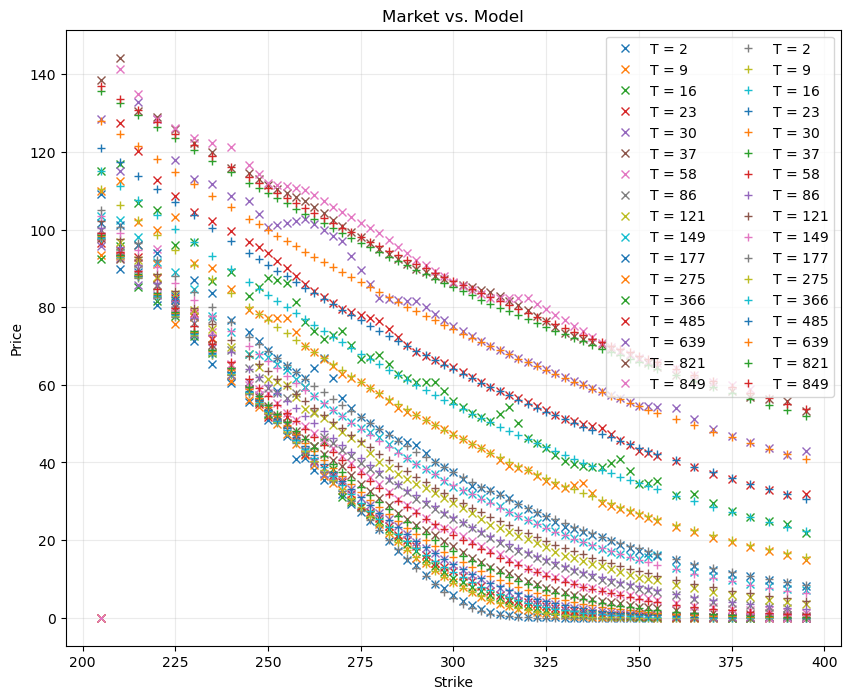

In [89]:
params2 = [ 1.70634539,  0.1844996,   0.5879795,  -0.37766673,  1.62891105]
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities_yr[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, meta_close, K, r, q, T, alpha, eta, n, model)
        modelPrices[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral

for i in range(len(maturities)):
    plt.plot(strikes, callPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model')

plt.show() 

In [92]:
fb_df.to_csv('fb_df_190923.xlsx', index=False)


In [8]:
# Puts
meta_close = 302.54998779296875
fb_df = pd.read_csv('fb_df_190923.csv')

In [9]:
fb_df.head()


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,inTheMoney,contractSize,currency,Option type,Maturity date,Mid,Maturity,Days to maturity,Years to maturity,Implied vol calc
0,META230922C00205000,2023-09-14 13:30:02+00:00,205.0,101.73,0.0,0.0,0.0,0.0,2.0,0.0,...,True,REGULAR,USD,Call,2023-09-22,101.73,2023-09-22,2,0.005556,4.250511e+00
1,META230922C00210000,2023-09-15 19:50:00+00:00,210.0,89.80,0.0,0.0,0.0,0.0,5.0,0.0,...,True,REGULAR,USD,Call,2023-09-22,89.80,2023-09-22,2,0.005556,6.738630e-13
2,META230922C00215000,2023-09-15 15:27:26+00:00,215.0,88.96,0.0,0.0,0.0,0.0,3.0,0.0,...,True,REGULAR,USD,Call,2023-09-22,88.96,2023-09-22,2,0.005556,2.911973e+00
3,META230922C00220000,2023-09-18 13:49:35+00:00,220.0,80.47,0.0,0.0,0.0,0.0,1.0,0.0,...,True,REGULAR,USD,Call,2023-09-22,80.47,2023-09-22,2,0.005556,4.191853e-13
4,META230922C00225000,2023-09-15 13:40:51+00:00,225.0,82.85,0.0,0.0,0.0,0.0,10.0,0.0,...,True,REGULAR,USD,Call,2023-09-22,82.85,2023-09-22,2,0.005556,3.720601e+00


In [10]:
fb_puts = fb_df[fb_df['Option type'] == 'Put'][['Days to maturity', 'strike', 'Mid']]

In [53]:
alpha = -1.5 # Change of alpha sign to ensure generic FFT function will produce puts instead of calls

In [48]:
marketPrices = putPrices

In [54]:
iArray = []
rmseArray = []
rmseMin = 1e10
for i in mfc.myRange(0, 1, 0.05):
    
    params = i*np.array(params1) + (1.0-i)*np.array(params2)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities_yr, strikes, r, q, meta_close, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

print(rmseMin)
print(optimParams)

C:\Users\pawpi\Downloads\modulesForCalibration.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  xX[j] = cmath.exp(-1j*beta*nuJ[j])*df*psi_nuJ[j]*wJ
C:\Users\pawpi\Downloads\modulesForCalibration.py:100: RuntimeWarning: overflow encountered in tanh
  tmp2 = ((u*u+1j*u)*v0)/(g/np.tanh(g*T/2)+tmp)


6.752913169085247
[ 8.6     0.1606  0.246  -0.2     2.    ]


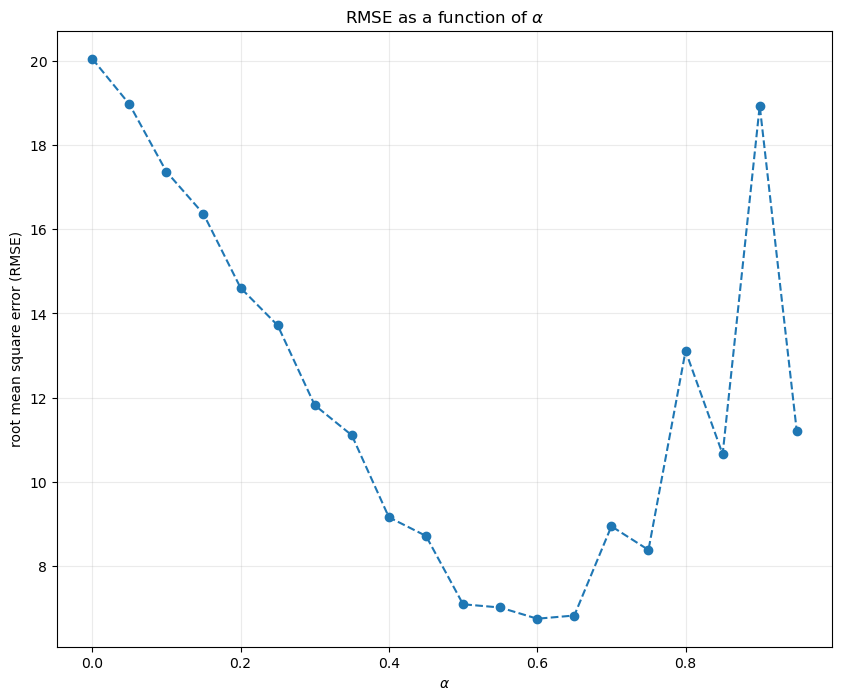

In [55]:
fig = plt.figure(figsize=(10,8))
plt.plot(iArray, rmseArray, 'o--')
plt.grid(alpha=0.25)
plt.xlabel('$\\alpha$')
plt.ylabel('root mean square error (RMSE)')
plt.title('RMSE as a function of $\\alpha$')
plt.show()

In [56]:
# Nelder Mead
from scipy.optimize import fmin
params = [ 8.6,     0.1606 ,  0.246 , -0.2 ,     2   ]

def callbackF(xi):
    global num_iter
    global arg
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities_yr, strikes, r, q, meta_close, alpha, eta, n, model)

num_iter = 1
#xopt, fopt, iters, funcalls, warnflag, allvecs = fmin(
t = fmin(
        mfc.eValue, 
        params, 
        args=arg, 
        xtol=1e-4,
        ftol=1e-4,
        maxiter=100,
        maxfun=400,
        callback=callbackF,
        disp=True,
        retall=False,
        full_output=True)

print('optimal params = ')
print(t[0])
print('f = ' + str(t[1]))

i = 1
x_i = [ 8.6     0.1606  0.246  -0.2     2.1   ]
f_i = 6.527605464786304
i = 2
x_i = [ 8.9612     0.1673452  0.23862   -0.1824     2.084    ]
f_i = 6.51594818310379
i = 3
x_i = [ 8.9612     0.1673452  0.23862   -0.1824     2.084    ]
f_i = 6.51594818310379
i = 4
x_i = [ 8.9612     0.1673452  0.23862   -0.1824     2.084    ]
f_i = 6.51594818310379
i = 5
x_i = [ 8.9612     0.1673452  0.23862   -0.1824     2.084    ]
f_i = 6.51594818310379
i = 6
x_i = [ 8.9612     0.1673452  0.23862   -0.1824     2.084    ]
f_i = 6.51594818310379
i = 7
x_i = [ 8.9612     0.1673452  0.23862   -0.1824     2.084    ]
f_i = 6.51594818310379
i = 8
x_i = [ 8.73536978  0.16682207  0.2388708  -0.19432332  2.08714534]
f_i = 6.515570313966373
i = 9
x_i = [ 8.74859028  0.16642659  0.24094063 -0.19567869  2.06418628]
f_i = 6.512119926641041
i = 10
x_i = [ 8.74859028  0.16642659  0.24094063 -0.19567869  2.06418628]
f_i = 6.512119926641041
i = 11
x_i = [ 8.74859028  0.16642659  0.24094063 -0.19567869  2.06418628]


f_i = 6.494986723688718
i = 85
x_i = [ 3.86671616  0.17349644  0.36458111 -0.37585431  2.08431603]
f_i = 6.4919709051077055
i = 86
x_i = [ 3.86671616  0.17349644  0.36458111 -0.37585431  2.08431603]
f_i = 6.4919709051077055
i = 87
x_i = [ 3.45099054  0.17391363  0.3756943  -0.39239005  2.08568476]
f_i = 6.491580514540129
i = 88
x_i = [ 3.45099054  0.17391363  0.3756943  -0.39239005  2.08568476]
f_i = 6.491580514540129
i = 89
x_i = [ 3.3429431   0.17402486  0.37833519 -0.39249837  2.09312752]
f_i = 6.49029940156309
i = 90
x_i = [ 3.3429431   0.17402486  0.37833519 -0.39249837  2.09312752]
f_i = 6.49029940156309
i = 91
x_i = [ 3.3429431   0.17402486  0.37833519 -0.39249837  2.09312752]
f_i = 6.49029940156309
i = 92
x_i = [ 3.3429431   0.17402486  0.37833519 -0.39249837  2.09312752]
f_i = 6.49029940156309
i = 93
x_i = [ 3.19048871  0.1744235   0.38206993 -0.40112783  2.08948626]
f_i = 6.490230696450794
i = 94
x_i = [ 3.28660427  0.17409909  0.37960075 -0.39678453  2.08945827]
f_i = 6.4901

C:\Users\pawpi\AppData\Local\Temp\ipykernel_19180\4244330578.py:17: RuntimeWarning: Maximum number of iterations has been exceeded.
  t = fmin(


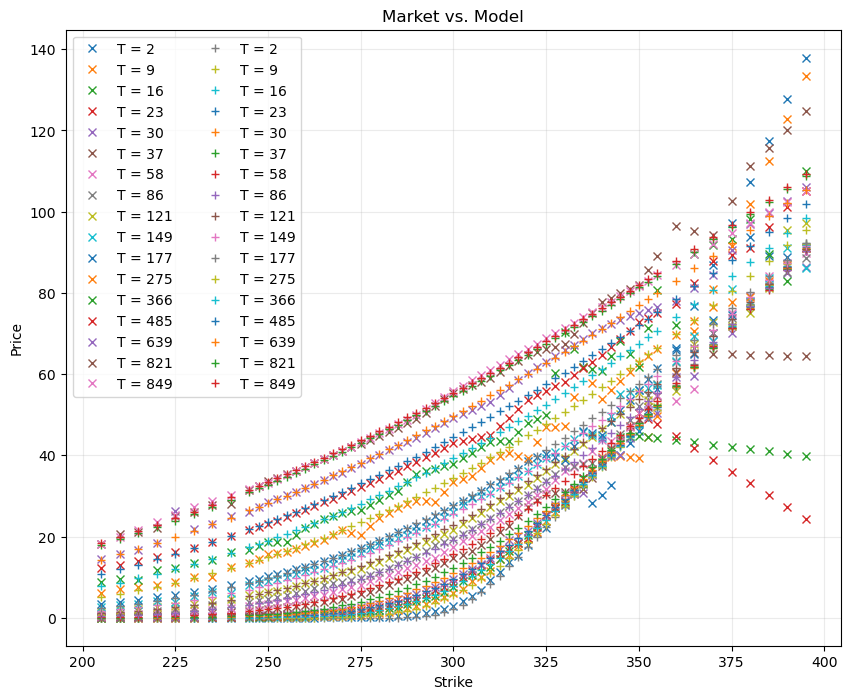

In [59]:
params2 = [ 3.0808203,  0.17438585,   0.38451403,  -0.40271929,  2.0924291]
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities_yr[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, meta_close, K, r, q, T, alpha, eta, n, model)
        modelPrices[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral

for i in range(len(maturities)):
    plt.plot(strikes, putPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper left', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model')

plt.show() 